In [12]:
import os
import pickle
from itertools import product
import logging
import copy
import random

import librosa
import numpy as np
from torch.utils.data import Dataset
import networkx as nx
from tqdm import tqdm
from scipy.io import wavfile
from scipy.signal import fftconvolve
from skimage.measure import block_reduce
from ss_baselines.common.utils import to_tensor
from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING

import os
import torch
import numpy as np
from soundspaces.utils import load_metadata
from ss_baselines.savi.pretraining_compare.audiogoal_predictor import AudioGoalPredictor_infer as AudioGoalPredictor
from ss_baselines.savi.pretraining_compare.audiogoal_dataset import AudioGoalDataset
from ss_baselines.savi.config.default import get_config
from soundspaces.mp3d_utils import SCENE_SPLITS


In [13]:

# -----------------------
# 1) 基本配置（你按需改）
# -----------------------
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CONFIG_PATH = "/home/Disk/sound-space/ss_baselines/savi/config/semantic_audionav/savi.yaml"
SPLIT = "val"                 # "train" / "val" / "test"
USE_CACHE = False             # 建议 inference 时 False，避免占用巨大内存
           # 你要看的 dataset index
PREDICT_LABEL = False
PREDICT_LOCATION = True

# 可选：加载 ckpt（设为 None 就不加载）
CKPT_PATH       = "data/models/savi_ral/laset_epoch.pth"   # or None
# CKPT_PATH_audio = "/media/kemove/data/sound-spaces/data/models/savi_final_ipd_tune/laset_epoch.pth"   # or None


# -----------------------
# 2) 构建 config / dataset
# -----------------------
config = get_config(config_paths=CONFIG_PATH, opts=None, run_type=None)
meta_dir = config.TASK_CONFIG.SIMULATOR.AUDIO.METADATA_DIR

scenes = SCENE_SPLITS[SPLIT]

scene_graphs = {}
for scene in scenes:
    points, graph = load_metadata(os.path.join(meta_dir, "mp3d", scene))
    scene_graphs[scene] = graph

dataset = AudioGoalDataset(
    scene_graphs=scene_graphs,
    scenes=scenes,
    split=SPLIT,
    use_polar_coordinates=True,
    use_cache=USE_CACHE,
)

print(f"[INFO] dataset split={SPLIT}, len={len(dataset)}")


# -----------------------
# 3) 构建模型 + 可选加载权重
# -----------------------
model = AudioGoalPredictor(
    predict_label=PREDICT_LABEL,
    predict_location=PREDICT_LOCATION
).to(DEVICE)
model.eval()


if CKPT_PATH is not None and os.path.exists(CKPT_PATH):
    ckpt = torch.load(CKPT_PATH, map_location="cpu")
    # 你的 trainer 存的是 {"audiogoal_predictor": state_dict}
    if "audiogoal_predictor" in ckpt:
        model.load_state_dict(ckpt["audiogoal_predictor"], strict=True)
        print(f"[INFO] loaded ckpt: {CKPT_PATH}")
    else:
        # 万一你保存的是裸 state_dict
        model.load_state_dict(ckpt, strict=True)
        print(f"[INFO] loaded ckpt (raw state_dict): {CKPT_PATH}")
else:
    print("[WARN] ckpt not loaded (path is None or not exists).")


[AudioGoalDataset] Load cache: /home/Disk/yyz/sound-spaces/cache/mp3d_val_pairs25000_polar1.npz
[INFO] dataset split=val, len=42452
[INFO] loaded ckpt: data/models/savi_ral/laset_epoch.pth


In [14]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# def goals_to_numpy(goals):
#     # goals: list[Tensor(3,)] or list[np.array]
#     if len(goals) == 0:
#         return np.zeros((0, 3), dtype=np.float32)
#     if torch.is_tensor(goals[0]):
#         g = torch.stack(goals, dim=0).cpu().numpy()  # (N,3)
#     else:
#         g = np.asarray(goals, dtype=np.float32)
#     return g

# def stats_from_dataset_goals(dataset, dist_min=1.0, dist_max=15.0, num_bins=14, plot=True):
#     g = goals_to_numpy(dataset.goals)   # (N,3) -> [label, x, y]
#     labels = g[:, 0].astype(np.int64)
#     xs = g[:, 1]
#     ys = g[:, 2]
#     dists = np.sqrt(xs*xs + ys*ys)

#     print(f"N goals: {len(dists)}")
#     if len(dists) > 0:
#         print(f"dist min/max/mean/std: {dists.min():.3f} / {dists.max():.3f} / {dists.mean():.3f} / {dists.std():.3f}")

#     # 分桶统计
#     edges = np.linspace(dist_min, dist_max, num_bins + 1)
#     counts, _ = np.histogram(dists, bins=edges)

#     total = counts.sum()
#     print("\nBin stats:")
#     for i in range(num_bins):
#         lo, hi = edges[i], edges[i+1]
#         ratio = counts[i] / total if total > 0 else 0
#         print(f"[{lo:4.1f}, {hi:4.1f}) m : {counts[i]:6d}  ({ratio*100:5.2f}%)")
#     if total > 0:
#         print("\nMax/Min bin count ratio:", counts.max() / max(counts.min(), 1))

#     # label 分布（可选）
#     uniq, cnt = np.unique(labels, return_counts=True)
#     print("\nLabel distribution (top 20):")
#     order = np.argsort(-cnt)
#     for u, c in list(zip(uniq[order], cnt[order]))[:20]:
#         print(f"label {u:3d}: {c}")

#     if plot and len(dists) > 0:
#         plt.figure(figsize=(8,4))
#         plt.hist(dists, bins=edges, edgecolor="black")
#         plt.xlabel("GT distance (m)")
#         plt.ylabel("Count")
#         plt.title(f"GT distance distribution [{dist_min},{dist_max}] m")
#         plt.grid(True, axis="y", linestyle="--", alpha=0.5)
#         plt.show()

#         # (x,y) scatter 看方向覆盖
#         plt.figure(figsize=(5,5))
#         plt.scatter(xs, ys, s=1, alpha=0.25)
#         plt.xlabel("x (m)")
#         plt.ylabel("y (m)")
#         plt.axis("equal")
#         plt.title("GT (x,y) distribution")
#         plt.grid(True, linestyle="--", alpha=0.3)
#         plt.show()

#     return dists, counts, edges

# # 用法
# dists, counts, edges = stats_from_dataset_goals(dataset, dist_min=1.0, dist_max=15.0, num_bins=14, plot=True)


========== SAMPLE ==========
Index: 7616

========== GT ==========
GT doa label: 149
pred doa   : tensor(189)
GT dis label: 23
pred dis   : tensor(24)


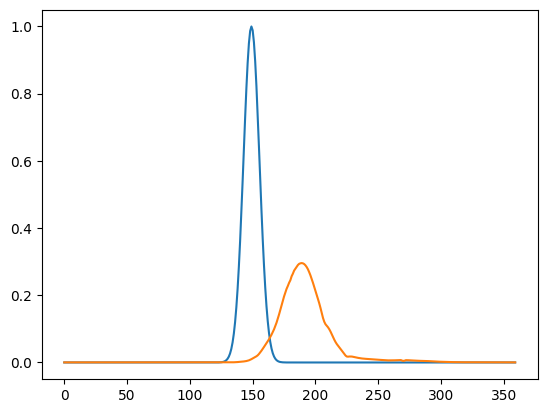

In [18]:
import matplotlib.pyplot as plt
# -----------------------
# 4) 取一个 sample，跑一次 forward
# -----------------------
# for SAMPLE_INDEX in range(100,200):
SAMPLE_INDEX = 7616
(inputs_list, gt) = dataset[SAMPLE_INDEX]      # inputs_list = [spectrogram], gt shape (3,)
spectrogram = inputs_list[0]                  # torch tensor, shape (2, 65, 26)
depth       = inputs_list[1]                  # torch tensor, shape (1, 128, 128)
gt_doa, gt_dis,_ = gt
# 加 batch 维度 -> (1, 2, 65, 26)
spec = spectrogram.unsqueeze(0).to(DEVICE, dtype=torch.float32)
spec = spec.permute(0,3,1,2)    # 变成 (1, 2, 26, 65)
depth = depth.unsqueeze(0).to(DEVICE, dtype=torch.float32)

with torch.no_grad():
    pred_doa,pred_dis = model(spec,depth)          # shape: (1, C) or (1, C+2) or (1,2)
    pred_doa = pred_doa.squeeze(0).cpu()
    pred_dis = pred_dis.squeeze(0).cpu()
    
gt_doa_np = gt_doa.cpu().numpy() if torch.is_tensor(gt_doa) else np.array(gt_doa)
gt_dis_np = gt_dis.cpu().numpy() if torch.is_tensor(gt_dis) else np.array(gt_dis)    
print("========== SAMPLE ==========")
print("Index:", SAMPLE_INDEX)
print("\n========== GT ==========")
# gt[0] 是 label index；gt[1:] 是 (x,y)
print("GT doa label:", int(np.argmax(gt_doa_np)))
print("pred doa   :", np.argmax(pred_doa))
print("GT dis label:", int(np.argmax(gt_dis)))
print("pred dis   :", np.argmax(pred_dis))
plt.plot(gt_doa_np)
plt.plot(pred_doa)



In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# =========================
# 0) 载入保存的 index
# =========================
NPZ_PATH = "vis/tsne_selected_indices.npz"  # 改成你的文件名
data = np.load(NPZ_PATH, allow_pickle=True)

sel_idx = data["sel_idx"].astype(int)
y = data["y"].astype(int)

# 可选：读取保存的配置（用于标注）
targets = data["targets"].astype(int) if "targets" in data else None
eps_deg = int(data["eps_deg"]) if "eps_deg" in data else None
max_err = int(data["max_pred_err_deg"]) if "max_pred_err_deg" in data else None

print("Loaded sel_idx:", sel_idx.shape, "labels y:", y.shape)

# =========================
# 1) feature hook（你之前那套 그대로）
# =========================
class FeatureHook:
    def __init__(self, module: torch.nn.Module):
        self.feat = None
        self.h = module.register_forward_hook(self._hook)

    def _hook(self, module, inp, out):
        self.feat = out if isinstance(out, torch.Tensor) else None

    def close(self):
        self.h.remove()

def find_feature_layer(m: torch.nn.Module):
    if hasattr(m, "doa_head") and isinstance(m.doa_head, torch.nn.Sequential) and len(m.doa_head) > 0:
        return m.doa_head[0]  # Linear
    if hasattr(m, "fusion_fc"):
        return m.fusion_fc
    if hasattr(m, "spec_encoder") and hasattr(m.spec_encoder, "fc"):
        return m.spec_encoder.fc
    raise ValueError("Cannot find feature layer automatically; please set layer manually.")

@torch.no_grad()
def extract_feature(model_feat, spec, depth, layer=None):
    model_feat.eval()
    if layer is None:
        layer = find_feature_layer(model_feat)
    hk = FeatureHook(layer)
    _ = model_feat(spec, depth)
    feat = hk.feat
    hk.close()
    if feat is None:
        raise RuntimeError("No feature captured. Check the hooked layer.")
    feat = feat.detach().cpu()
    while feat.dim() > 2:
        feat = feat.mean(dim=-1)
    feat = feat.squeeze(0).numpy()
    return feat

# =========================
# 2) 用 sel_idx 提取特征
# =========================
X_fusion, X_audio = [], []
for idx in sel_idx:
    (inputs_list, gt) = dataset[int(idx)]
    spectrogram = inputs_list[0]
    depth       = inputs_list[1]

    spec_t  = spectrogram.unsqueeze(0).to(DEVICE, dtype=torch.float32)
    spec_t  = spec_t.permute(0,3,1,2)    # 变成 (1, 2, 26, 65)
    depth_t = depth.unsqueeze(0).to(DEVICE, dtype=torch.float32)

    X_fusion.append(extract_feature(model, spec_t, depth_t))
    # X_audio.append(extract_feature(model_audio, spec_t, depth_t))

X_fusion = np.asarray(X_fusion, dtype=np.float32)
# X_audio  = np.asarray(X_audio,  dtype=np.float32)

# print("Feature shapes:", X_fusion.shape, X_audio.shape)

# =========================
# 3) t-SNE
# =========================


Loaded sel_idx: (1440,) labels y: (1440,)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1440 samples in 0.000s...
[t-SNE] Computed neighbors for 1440 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1440
[t-SNE] Computed conditional probabilities for sample 1440 / 1440
[t-SNE] Mean sigma: 5.414308
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.914524
[t-SNE] KL divergence after 1500 iterations: 0.690242


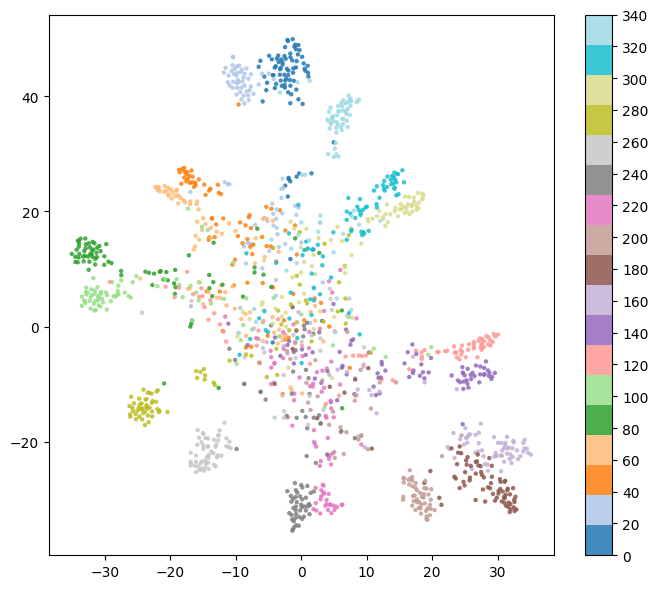

In [31]:
TSNE_PERPLEXITY = 40
TSNE_LR = 200
TSNE_ITERS = 1500
SEED = int(data["seed"]) if "seed" in data else 0

def run_tsne(X, seed=0):
    tsne = TSNE(
        n_components=2,
        perplexity=TSNE_PERPLEXITY,
        learning_rate=TSNE_LR,
        n_iter=TSNE_ITERS,
        init="pca",
        random_state=seed,
        verbose=1,
    )
    return tsne.fit_transform(X)

Z_fusion = run_tsne(X_fusion, seed=SEED)
# Z_audio  = run_tsne(X_audio,  seed=SEED)

# =========================
# 4) 画图
# =========================
def plot_tsne(Z, y, title, targets=None):
    plt.figure(figsize=(7, 6))
    n_classes = int(np.max(y)) + 1
    cmap = plt.cm.get_cmap("tab20", n_classes)
    sc = plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap=cmap, s=10, alpha=0.85, linewidths=0)
    # plt.title(title)
    # plt.axis("off")

    # colorbar 标签用 targets（0,20,...,340）更直观
    if targets is not None and len(targets) == n_classes:
        ticks = np.arange(n_classes)
        cbar = plt.colorbar(sc, ticks=ticks)
        cbar.ax.set_yticklabels([str(int(t)) for t in targets])
        plt.tight_layout()
    else:
        plt.colorbar(sc)
        plt.tight_layout()

    plt.savefig(
    "vis/tsne_lsasa",
    dpi=600,
    transparent=True,  
    bbox_inches="tight",
    pad_inches=0.02
    )
    plt.show()

suffix = ""
if (targets is not None) and (eps_deg is not None) and (max_err is not None):
    suffix = f" (targets=0..340 step20, ±{eps_deg}°, err≤{max_err}°)"

plot_tsne(Z_fusion, y, "t-SNE (Fusion features)" + suffix, targets=targets)
# plot_tsne(Z_audio,  y, "t-SNE (Audio-only features)" + suffix, targets=targets)
